## ISMIR 2016 -- MSAF Experiments ##

The idea is to run various experiments to illustrate the impact that hyper parameters have in different levels of implementation of a Music Structure Analysis system.

The following domains will be explored:
* features
* algorithms
* evaluations
* datasets

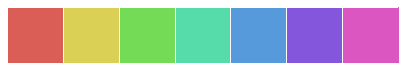

In [114]:
import glob
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import scipy
import seaborn as sns
from scipy.stats import friedmanchisquare

from statsmodels.stats.multicomp import (pairwise_tukeyhsd,
                                         MultiComparison)
from statsmodels.formula.api import ols
from statsmodels.graphics.api import interaction_plot, abline_plot
from statsmodels.stats.anova import anova_lm

import msaf

# Plotting settings
%matplotlib inline
sns.set_style("dark")
sns.set_style("darkgrid", {'legend.frameon': True})

# Colors
colors_bounds = sns.color_palette("hls", 7)
colors_labels = sns.color_palette("deep", 5)
sns.palplot(sns.color_palette("hls", 7))

colors = ['b', 'g', 'r', 'm', 'k', 'c', 'y']
markers = ['D', '^', '*', 'd', 'o', '.', '_']
markers_labels = ['D', '^', '*', 'd', '.']

## Features ##

Use the Checkerboard Kernel method (Foote) in the BeatlesTUT dataset using different analisys windows when computing the features.
More specifically, we fix the sampling rate (11025Hz) and explore the following params:

* Analysis window sizes: [2048, 4096] (in samples)
* Amount of overlap [50%, 75%, 87.5%]

Additionally, we show that beat-synchronous features produce significantly different results using a window of 4096 samples with 87.5% overlap.

In [115]:
framesync = True
anal_data_keys = ["frame2048_hop256", "frame2048_hop512", "frame2048_hop1024",
                  "frame4096_hop512", "frame4096_hop1024", "frame4096_hop2048"]
results = {}
for anal_data_key in anal_data_keys:
    results[anal_data_key] = pd.read_csv("../data/results_" + anal_data_key + ".csv")

In [116]:
metrics = ["HitRate_3F", "HitRate_3P", "HitRate_3R"]
# metrics = ["HitRate_t3F", "HitRate_t3P", "HitRate_t3R"]
# metrics = ["HitRate_t0.5F", "HitRate_t0.5P", "HitRate_t0.5R"]

In [117]:
print scipy.stats.ttest_rel(results["frame4096_hop2048"][metrics].values,
                            results["frame2048_hop256"][metrics].values)

Ttest_relResult(statistic=array([ 4.46395307,  8.73830081, -2.28262264]), pvalue=array([  1.44676017e-05,   1.99345977e-15,   2.36698026e-02]))


In [118]:
# Multi-comparison Holm–Bonferroni, step-down method
def add_data(data, results, key, metrics):
    for scores in results[key][metrics].values:
        data.append((key, scores[0]))
        data.append((key, scores[1]))
        data.append((key, scores[2]))

data = []
for anal_data_key in anal_data_keys:
    add_data(data, results, anal_data_key, metrics)
data = np.rec.array(data, dtype=[('Params', '|S24'),('Score', '>f4')])
mod = MultiComparison(data["Score"], data["Params"])

# step-down method using Bonferroni adjustments
# see: http://en.wikipedia.org/wiki/Holm%E2%80%93Bonferroni_method
print mod.allpairtest(scipy.stats.ttest_rel, method='holm')[0]

Test Multiple Comparison ttest_rel 
FWER=0.05 method=holm
alphacSidak=0.00, alphacBonf=0.003
      group1            group2        stat   pval  pval_corr reject
-------------------------------------------------------------------
frame2048_hop1024  frame2048_hop256  5.4538  0.0      0.0     True 
frame2048_hop1024  frame2048_hop512  3.2704 0.0011   0.0114   True 
frame2048_hop1024 frame4096_hop1024   nan    nan      nan    False 
frame2048_hop1024 frame4096_hop2048 -2.4104 0.0163   0.0651  False 
frame2048_hop1024  frame4096_hop512  3.2704 0.0011   0.0114   True 
 frame2048_hop256  frame2048_hop512 -2.8536 0.0045   0.027    True 
 frame2048_hop256 frame4096_hop1024 -5.4538  0.0      0.0     True 
 frame2048_hop256 frame4096_hop2048 -6.2674  0.0      0.0     True 
 frame2048_hop256  frame4096_hop512 -2.8536 0.0045   0.027    True 
 frame2048_hop512 frame4096_hop1024 -3.2704 0.0011   0.0114   True 
 frame2048_hop512 frame4096_hop2048 -5.0085  0.0      0.0     True 
 frame2048_hop512  fram

In [119]:
# Test Beat synchronous
results["frame4096_hop512_bs"] = pd.read_csv("../data/results_frame4096_hop512_bs.csv")
print scipy.stats.ttest_ind(results["frame4096_hop512_bs"][metrics].values,
                            results["frame4096_hop512"][metrics].values)

Ttest_indResult(statistic=array([ 3.67342772,  6.35678455,  0.09211639]), pvalue=array([  2.77195189e-04,   6.50615306e-10,   9.26658880e-01]))


## Features (pt 2)

Analyze the impact of the following parameters of these two features:

* Chroma:
    * Number of Octaves: $n\_octaves = [3, ..., 7]$
    * Minimum frequency: $f\_min = [27.5 \cdot 2 ^{0/12}, 27.5 \cdot 2 ^ {1/12}, ..., 27.5 \cdot 2 ^ {12/12}]$
    
* MFCC:
    * n_coeff

Use the following algorithms to explore the impact on the results:

* **Checkerboard Kernel**: Focused on Novelty segments.
* **Convex NMF**: Focused on Homogeneous segments.
* **Structural Features**: Focused on both types of segments.



In [120]:
n_octaves = [4, 5, 6, 7]
f_mins = [27.5 * 2 ** (i / 12.) for i in xrange(0, 12, 2)]
data_path = "../data/"
algorithm_dict = {
    "cc" : "Constrained Clustering",
    "cnmf": "Convex NMF",
    "fmc2d": "2D Fourier Magnitude Coeffs",
    "foote": "Checkerboard Kernel",
    "sf": "Structural Features",
    "scluster": "Laplacian Segmentation",
    "siplca": "Shift-Invariant PLCA",
    "olda": "Ordinal LDA"
}

In [121]:
def get_score(csv_file, metric="HitRate_3F"):
    """Get average score from a certain file."""
    results = pd.read_csv(csv_file)
    return results[metric]

def get_algorithm_id(csv_file, algo_type="bounds"):
    """Returns the name of the algorithm contained in the file name."""
    base_file = os.path.basename(csv_file)
    params = base_file.split("_")
    for param in params:
        if algo_type in param:
            return param.split("E")[-1]
        
def split_result_files(results_files):
    """Splits the files into boundaries and labels."""
    bound_files = []
    labels_files = []
    for result_file in results_files:
        if get_algorithm_id(result_file, algo_type="bounds") == "gt":
            labels_files.append(result_file)
        else:
            bound_files.append(result_file)
    return bound_files, labels_files

In [122]:
# Read scores
bound_metric = "HitRate_3F"
label_metric = "PWF"
boundsID_str = "_boundIDs"
labelsID_str = "_labelsIDs"
bound_scores = {}
label_scores = {}
for n_octave in n_octaves:
    for f_min in f_mins:
        if n_octave == 7 and f_min > 40:
            continue
        key = "noctavesE%d_fminE%.1f" % (n_octave, f_min)
        results_files = glob.glob(os.path.join(data_path, 
                                               "results_%s" % key,
                                               "*.csv"))
        bound_files, labels_files = split_result_files(results_files)
        bound_scores[key] = [get_score(results_file, bound_metric)
                       for results_file in bound_files]
        bound_scores[key + boundsID_str] = [get_algorithm_id(results_file)
                       for results_file in bound_files]
        label_scores[key] = [get_score(results_file, label_metric)
                       for results_file in labels_files]
        label_scores[key + labelsID_str] = [get_algorithm_id(results_file, algo_type="labels")
                       for results_file in labels_files]

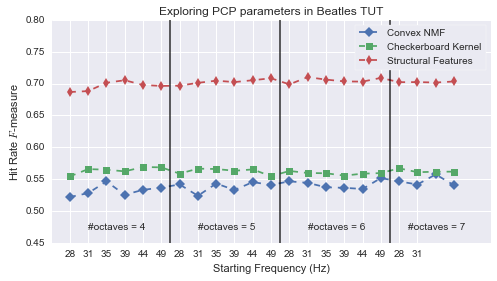

In [123]:
# Plot bound scores
sns.set_style("darkgrid", {'legend.frameon': True})
plt.figure(figsize=(7, 4))
algo_scores = {}
params = []
for n_octave in n_octaves:
    for f_min in f_mins:
        if n_octave == 7 and f_min > 40:
            continue
        key = "noctavesE%d_fminE%.1f" % (n_octave, f_min)
        for i, bound_id in enumerate(bound_scores[key + boundsID_str]):
            if bound_id not in algo_scores.keys():
                algo_scores[bound_id] = []
            algo_scores[bound_id].append(bound_scores[key][i].mean())
        params.append(key)

marks = ["D", "s", "d"]
for i, bound_id in enumerate(algo_scores.keys()):
    plt.plot(algo_scores[bound_id], "--%s" % marks[i], label=algorithm_dict[bound_id])
n_params = len(params) - 2
x_offset = 1
plt.xticks(xrange(n_params))
plt.gca().set_xticklabels(4 * [ "%.0f" % f_min for f_min in f_mins])
plt.xlim((-x_offset, n_params + x_offset + 2))
plt.xlabel("Starting Frequency (Hz)")
plt.ylim((0.45, .8))
plt.ylabel("Hit Rate $F$-measure")
plt.title("Exploring PCP parameters in Beatles TUT")
plt.legend()

# Add octave bars
for i in xrange(len(n_octaves)):
    plt.axvline((i + 1) * len(f_mins) - .5, color="k", alpha=0.7)
    x_off = 1
    if i == 3:
        x_off = 0.5
    plt.text((i) * len(f_mins) + x_off, 0.47, "#octaves = %d" % n_octaves[i])
plt.tight_layout()
plt.savefig("../figs/features_bounds.pdf")
plt.show()

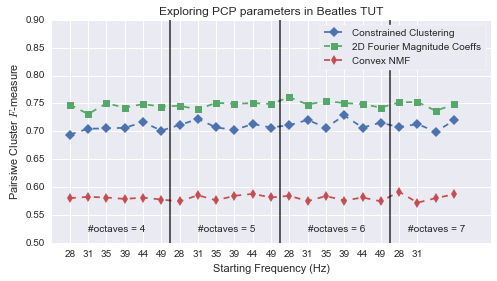

In [124]:
# Plot bound scores
sns.set_style("darkgrid", {'legend.frameon': True})
plt.figure(figsize=(7, 4))
algo_scores = {}
params = []
for n_octave in n_octaves:
    for f_min in f_mins:
        if n_octave == 7 and f_min > 40:
            continue
        key = "noctavesE%d_fminE%.1f" % (n_octave, f_min)
        for i, bound_id in enumerate(label_scores[key + labelsID_str]):
            if bound_id not in algo_scores.keys():
                algo_scores[bound_id] = []
            algo_scores[bound_id].append(label_scores[key][i].mean())
        params.append(key)

marks = ["D", "s", "d"]
for i, label_id in enumerate(algo_scores.keys()):
    plt.plot(algo_scores[label_id], "--%s" % marks[i], label=algorithm_dict[label_id])
n_params = len(params) - 2
x_offset = 1
plt.xticks(xrange(n_params))
plt.gca().set_xticklabels(4 * [ "%.0f" % f_min for f_min in f_mins])
plt.xlim((-x_offset, n_params + x_offset + 2))
plt.xlabel("Starting Frequency (Hz)")
plt.ylim((0.5, .9))
plt.ylabel("Pairsiwe Cluster $F$-measure")
plt.title("Exploring PCP parameters in Beatles TUT")
plt.legend(loc=1)

# Add octave bars
for i in xrange(len(n_octaves)):
    plt.axvline((i + 1) * len(f_mins) - .5, color="k", alpha=0.7)
    x_off = 1
    if i == 3:
        x_off = 0.5
    plt.text((i) * len(f_mins) + x_off, 0.52, "#octaves = %d" % n_octaves[i])
plt.tight_layout()
plt.savefig("../figs/features_labels.pdf")
plt.show()

In [125]:
def get_bound_dataframe(algo_id):
    octave_numbers = []
    min_frequencies = []
    scores = []
    for n_octave in n_octaves:
        for f_min in f_mins:
            if n_octave == 7 and f_min > 40:
                continue
            key = "noctavesE%d_fminE%.1f" % (n_octave, f_min)
            algo_name = bound_scores[key + boundsID_str][algo_id]
            for score in bound_scores[key][algo_id]:
                octave_numbers.append(n_octave)
                min_frequencies.append(f_min)
                scores.append(score)

    # To DataFrame
    d = { 
         "Octave"  : np.asarray(octave_numbers),
         "Frequency" : np.asarray(min_frequencies),
         "Score"      : np.asarray(scores)
        }
    df = pd.DataFrame(d)
    return df, algo_name

# PLOT
# plt.figure(figsize=(7,5))
# interaction_plot(df["Frequency"], df["Octave"],
#                  df["Score"], colors=['b', 'g', 'r'],
#                  markers=['D', '^', '*'], ms=9, ax=plt.gca(), legendloc="lower center")
# plt.gca().set_ylim([0.2, 0.8])
# plt.tight_layout()
# plt.savefig("control-ANOVA-F3.pdf")
# plt.show()

# Structural Features
df, algo_name = get_bound_dataframe(0)
sum_lm = ols("Score ~ C(Frequency, Sum) * C(Octave, Sum)", data=df).fit()
print algo_name, anova_lm(sum_lm, typ=1)

# Checkerboard Kernel
df, algo_name = get_bound_dataframe(1)
sum_lm = ols("Score ~ C(Frequency, Sum) * C(Octave, Sum)", data=df).fit()
print algo_name, anova_lm(sum_lm, typ=2)

# Convex NMF
df, algo_name = get_bound_dataframe(2)
sum_lm = ols("Score ~ C(Frequency, Sum) * C(Octave, Sum)", data=df).fit()
print algo_name, anova_lm(sum_lm, typ=2)

sf                                       df     sum_sq   mean_sq         F  \
C(Frequency, Sum)                    5.0   0.031637  0.006327  0.309619   
C(Octave, Sum)                       3.0   0.050452  0.016817  0.822928   
C(Frequency, Sum):C(Octave, Sum)    15.0   0.077387  0.005159  0.252452   
Residual                          3806.0  77.779666  0.020436       NaN   

                                    PR(>F)  
C(Frequency, Sum)                 0.907419  
C(Octave, Sum)                    0.481046  
C(Frequency, Sum):C(Octave, Sum)  0.998344  
Residual                               NaN  
foote                                         sum_sq      df             F    PR(>F)
C(Frequency, Sum)                 9.277252e-14     5.0  8.829315e-13  1.000000
C(Octave, Sum)                   -9.381217e-14     3.0 -1.488043e-12  1.000000
C(Frequency, Sum):C(Octave, Sum)  3.827783e-01    15.0  1.214322e+00  0.252175
Residual                          7.998179e+01  3806.0           NaN      

In [126]:
def get_label_dataframe(algo_id):
    octave_numbers = []
    min_frequencies = []
    scores = []
    for n_octave in n_octaves:
        for f_min in f_mins:
            if n_octave == 7 and f_min > 40:
                continue
            key = "noctavesE%d_fminE%.1f" % (n_octave, f_min)
            algo_name = label_scores[key + labelsID_str][algo_id]
            for score in label_scores[key][algo_id]:
                octave_numbers.append(n_octave)
                min_frequencies.append(f_min)
                scores.append(score)

    # To DataFrame
    d = { 
         "Octave"  : np.asarray(octave_numbers),
         "Frequency" : np.asarray(min_frequencies),
         "Score"      : np.asarray(scores)
        }
    df = pd.DataFrame(d)
    return df, algo_name

# PLOT
# plt.figure(figsize=(7,5))
# interaction_plot(df["Frequency"], df["Octave"],
#                  df["Score"], colors=['b', 'g', 'r'],
#                  markers=['D', '^', '*'], ms=9, ax=plt.gca(), legendloc="lower center")
# plt.gca().set_ylim([0.2, 0.8])
# plt.tight_layout()
# plt.savefig("control-ANOVA-F3.pdf")
# plt.show()

# Convex NMF
df, algo_name = get_label_dataframe(0)
sum_lm = ols("Score ~ C(Frequency, Sum) * C(Octave, Sum)", data=df).fit()
print algo_name, anova_lm(sum_lm, typ=2)

# 2D-FMC
df, algo_name = get_label_dataframe(1)
sum_lm = ols("Score ~ C(Frequency, Sum) * C(Octave, Sum)", data=df).fit()
print algo_name, anova_lm(sum_lm, typ=2)

# Constrained Cluster
df, algo_name = get_label_dataframe(2)
sum_lm = ols("Score ~ C(Frequency, Sum) * C(Octave, Sum)", data=df).fit()
print algo_name, anova_lm(sum_lm, typ=2)

cnmf                                         sum_sq      df             F    PR(>F)
C(Frequency, Sum)                -1.222235e-12     5.0 -1.753909e-11  1.000000
C(Octave, Sum)                    4.733979e-13     3.0  1.132211e-11  1.000000
C(Frequency, Sum):C(Octave, Sum)  3.930238e-02    15.0  1.879966e-01  0.999724
Residual                          5.304523e+01  3806.0           NaN       NaN
fmc2d                                         sum_sq      df             F  PR(>F)
C(Frequency, Sum)                -3.272442e-12     5.0 -3.727887e-11     1.0
C(Octave, Sum)                    5.547095e-13     3.0  1.053186e-11     1.0
C(Frequency, Sum):C(Octave, Sum) -6.188097e-04    15.0 -2.349777e-03     1.0
Residual                          6.682023e+01  3806.0           NaN     NaN
cc                                         sum_sq      df             F  PR(>F)
C(Frequency, Sum)                 1.327201e-12     5.0  1.282815e-11     1.0
C(Octave, Sum)                    7.920661e-12     3

In [127]:
results_features_path = "results_feature_types"
results_features_files = glob.glob(os.path.join(data_path, results_features_path, "*.csv"))
bound_metric = "HitRate_3F"
label_metric = "PWF"
xticks = ["CQT", "PCP", "MFCC", "Tonnetz"]

def get_result_attributes(result_file, algo_type="bounds"):
    algo_id = None
    feature = None
    annotator = None
    for param in os.path.basename(result_file)[:-4].split("_"):
        if algo_type in param and algo_id is None:
            algo_id = param.split("E")[1]
        if "feature" in param:
            feature = param.split("E")[1]
        if "annotator" in param:
            annotator = param.split("E")[1]
    return algo_id, feature, annotator

['Checkerboard Kernel' 'Constrained Clustering' 'Convex NMF'
 'Laplacian Segmentation' 'Shift-Invariant PLCA' 'Structural Features']


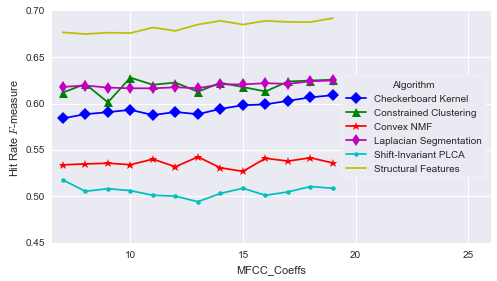

                                           sum_sq       df           F  \
C(Algorithm, Sum)                       46.251670      5.0  463.931255   
C(MFCC_Coeffs, Sum)                      0.155026     12.0    0.647918   
C(Algorithm, Sum):C(MFCC_Coeffs, Sum)    0.291849     60.0    0.243951   
Residual                               269.057122  13494.0         NaN   

                                         PR(>F)  
C(Algorithm, Sum)                      0.000000  
C(MFCC_Coeffs, Sum)                    0.802407  
C(Algorithm, Sum):C(MFCC_Coeffs, Sum)  1.000000  
Residual                                    NaN  


In [128]:
# MFCC coeffs
results_mfcc_dirs = glob.glob(os.path.join(data_path, "results_mfcc_coeffE*"))

# ANOVA on Boundaries
algo_ids = []
coeffs = []
scores = []
for mfcc_dir in results_mfcc_dirs:
    coeff = int(os.path.basename(mfcc_dir).split('E')[-1])
    results_mfcc = glob.glob(os.path.join(mfcc_dir, "*.csv"))
    for curr_file in results_mfcc:
        algo_id, feature, annotator = get_result_attributes(curr_file, "bounds")
        if algo_id == "olda":
            continue
        if "labelsENone" in curr_file:
            results = pd.read_csv(curr_file)
            for result in results[bound_metric]:
                scores.append(result)
                coeffs.append(coeff)
                algo_ids.append(algorithm_dict[algo_id])

# To DataFrame
d = { 
     "Algorithm"  : np.asarray(algo_ids),
     "MFCC_Coeffs" : np.asarray(coeffs),
     "Score"      : np.asarray(scores)
    }
df = pd.DataFrame(d)

print np.unique(df["Algorithm"])

# PLOT
plt.figure(figsize=(7,4))
interaction_plot(df["MFCC_Coeffs"], df["Algorithm"],
                 df["Score"], colors=['b', 'g', 'r', 'm', 'c', 'y'],
                 markers=['D', '^', '*', 'd', '.', '_'], ms=9, ax=plt.gca(), legendloc="center right")
plt.gca().set_ylim([.45, .7])
plt.gca().set_xlim([6.5, 26.])
plt.ylabel("Hit Rate $F$-measure")
plt.tight_layout()
plt.savefig("../figs/features_bounds_mfcc_anova.pdf")
plt.show()

sum_lm = ols("Score ~ C(Algorithm, Sum) * C(MFCC_Coeffs, Sum)", data=df).fit()
print anova_lm(sum_lm, typ=2)

['2D Fourier Magnitude Coeffs' 'Constrained Clustering' 'Convex NMF'
 'Laplacian Segmentation' 'Shift-Invariant PLCA']


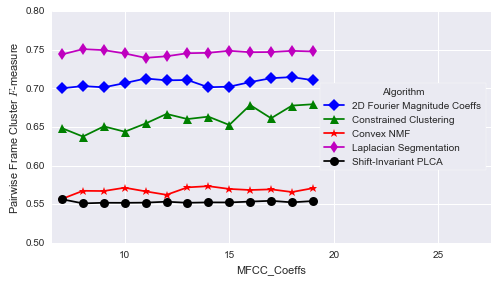

                                           sum_sq       df           F  \
C(Algorithm, Sum)                       64.999249      4.0  917.362183   
C(MFCC_Coeffs, Sum)                      0.138432     12.0    0.651248   
C(Algorithm, Sum):C(MFCC_Coeffs, Sum)    0.355841     48.0    0.418511   
Residual                               199.189744  11245.0         NaN   

                                         PR(>F)  
C(Algorithm, Sum)                      0.000000  
C(MFCC_Coeffs, Sum)                    0.799359  
C(Algorithm, Sum):C(MFCC_Coeffs, Sum)  0.999870  
Residual                                    NaN  


In [129]:
# MFCC ANOVA on Labels
algo_ids = []
coeffs = []
scores = []
for mfcc_dir in results_mfcc_dirs:
    coeff = int(os.path.basename(mfcc_dir).split('E')[-1])
    results_mfcc = glob.glob(os.path.join(mfcc_dir, "*.csv"))
    for curr_file in results_mfcc:
        algo_id, feature, annotator = get_result_attributes(curr_file, "labels")
        if algo_id == "olda":
            continue
        if "boundsEgt" in curr_file:
            results = pd.read_csv(curr_file)
            for result in results[label_metric]:
                scores.append(result)
                coeffs.append(coeff)
                algo_ids.append(algorithm_dict[algo_id])

# To DataFrame
d = { 
     "Algorithm"  : np.asarray(algo_ids),
     "MFCC_Coeffs" : np.asarray(coeffs),
     "Score"      : np.asarray(scores)
    }
df = pd.DataFrame(d)

print np.unique(df["Algorithm"])

# PLOT
plt.figure(figsize=(7,4))
interaction_plot(df["MFCC_Coeffs"], df["Algorithm"],
                 df["Score"], colors=['b', 'g', 'r', 'm', 'k'],
                 markers=['D', '^', '*', 'd', 'o'], ms=9, ax=plt.gca(), legendloc="center right")
plt.gca().set_ylim([.5, .8])
plt.gca().set_xlim([6.5, 27.5])
plt.ylabel("Pairwise Frame Cluster $F$-measure")
plt.tight_layout()
plt.savefig("../figs/features_labels_mfcc_anova.pdf")
plt.show()

sum_lm = ols("Score ~ C(Algorithm, Sum) * C(MFCC_Coeffs, Sum)", data=df).fit()
print anova_lm(sum_lm, typ=2)

### Feature Types ###

* PCP
* MFCC
* Tonnetz
* CQT


In [130]:
# From: http://adorio-research.org/wordpress/?p=239

from scipy import stats
 
def isequalfloats(a, b, ztol = 1.0e-8):
    return True if  abs(a-b) < ztol else False
 
def friedman(G, alpha = 0.05, ignoreties = False, onetailed = True, verbose = True):
    """
    Performs Friedman's test.
     G -array of arrays(groups). First group is G[0]
        each group mus have the same number of elements!
 
    """
    nclasses = len(G)                      # number of groups
    nblocks  = len(G[0])
    Rank     = [0]* nclasses               # ranks array.
 
    for j in range(nblocks):
        # get the rows.
        row = []
        for i in range(nclasses):
            row.append((G[i][j], i))
        row.sort()
 
        start  = 0
        while start < nclasses:
            end = start
            for k in range(start+1, nclasses):
                if not isequalfloats(row[k-1][0], row[k][0]):
                    end = k-1
                    break
            if end > start:
                rank = (start + end)/2.0 + 1
            else:
                rank = start + 1
 
            for k in range(start, end+1):
                index = row[k][1]     
                Rank[index] += rank
            start = end + 1
 
    sumRankssqr = sum([rank * rank for rank in Rank])
 
    #Compute Friedman statistic.
    Friedman = 12.0/(nblocks * nclasses*(nclasses+1))*sumRankssqr-3*(nclasses +1) *nblocks
    df = nclasses -1
 
    if verbose:
        print "Friedman test"
        print "Test statistic:", Friedman
        print "Class rank sums:", 
        for rank in Rank: 
            print rank,
            print
            print "p-value for ", nclasses-1, "degree of freedom:", stats.chi2.sf(Friedman, df)
            print "class ranks"
        for i, rank in enumerate(Rank):
            print "%3d %6.1f" %(i+1, rank)
    return Friedman
 
#Example from Berenson.
G = [
#     [70, 77, 76, 80, 84, 78],
#      [61, 75, 67,63,66, 68],
#      [82, 88,90, 96,92,98],
#      [74, 76, 80, 76, 84, 86],
    [74, 76, 80, 76, 84, 86],
    [84, 86, 90, 96, 94, 96]]

friedman(G, alpha = 0.05, ignoreties = False, onetailed = True, verbose = True)

Friedman test
Test statistic: 6.0
Class rank sums: 6
p-value for  1 degree of freedom: 0.0143058784354
class ranks
12
p-value for  1 degree of freedom: 0.0143058784354
class ranks
  1    6.0
  2   12.0


6.0

['Checkerboard Kernel' 'Constrained Clustering' 'Convex NMF'
 'Shift-Invariant PLCA' 'Structural Features']


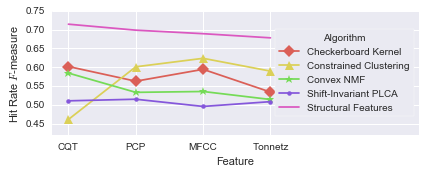

                                      sum_sq      df           F  \
C(Algorithm, Sum)                  14.034620     4.0  172.688827   
C(Feature, Sum)                     0.255801     3.0    4.196662   
C(Algorithm, Sum):C(Feature, Sum)   3.693566    12.0   15.149146   
Residual                           70.299547  3460.0         NaN   

                                          PR(>F)  
C(Algorithm, Sum)                  5.040358e-135  
C(Feature, Sum)                     5.667868e-03  
C(Algorithm, Sum):C(Feature, Sum)   1.436419e-31  
Residual                                     NaN  
Friedman test
Test statistic: 76.14
Class rank sums: 2349.5
p-value for  3 degree of freedom: 2.06419691013e-16
class ranks
2319.5
p-value for  3 degree of freedom: 2.06419691013e-16
class ranks
2079.5
p-value for  3 degree of freedom: 2.06419691013e-16
class ranks
1951.5
p-value for  3 degree of freedom: 2.06419691013e-16
class ranks
  1 2349.5
  2 2319.5
  3 2079.5
  4 1951.5
FriedmanchisquareResult

In [131]:
# ANOVA on Boundaries
algo_ids = []
features = []
scores = []
G = []
for curr_file in results_features_files:
    algo_id, feature, annotator = get_result_attributes(curr_file, "bounds")
    if algo_id == "olda" or algo_id == "scluster":
        continue
    if "labelsENone" in curr_file:
        results = pd.read_csv(curr_file)
        G.append(results[bound_metric])
        for result in results[bound_metric]:
            scores.append(result)
            features.append(feature)
            algo_ids.append(algorithm_dict[algo_id])

# To DataFrame
d = { 
     "Algorithm"  : np.asarray(algo_ids),
     "Feature" : np.asarray(features),
     "Score"      : np.asarray(scores)
    }
df = pd.DataFrame(d)

print np.unique(df["Algorithm"])
N = len(np.unique(df["Algorithm"]))

# PLOT
plt.figure(figsize=(6,2.5))
interaction_plot(df["Feature"], df["Algorithm"],
                 df["Score"], colors=colors_bounds[:3] + colors_bounds[5:7],
                 markers=markers[:3] + markers[5:7], ms=9, ax=plt.gca(), legendloc="center right")
# interaction_plot(df["Feature"], df["Algorithm"],
#                  df["Score"], colors=colors_bounds[:7],
#                  markers=markers[:7], ms=9, ax=plt.gca(), legendloc="center right")
plt.gca().set_ylim([0.42, 0.75])
plt.gca().set_xlim([-0.25, 5.2])
plt.ylabel("Hit Rate $F$-measure")
plt.gca().set_xticklabels(xticks)
plt.tight_layout()
plt.savefig("../figs/features_bounds_anova.pdf")
plt.show()

sum_lm = ols("Score ~ C(Algorithm, Sum) * C(Feature, Sum)", data=df).fit()
print anova_lm(sum_lm, typ=2)

G = np.asarray(G).reshape((len(np.unique(df["Feature"])), 174 * len(np.unique(df["Algorithm"])))) 
# G = np.asarray(G).reshape((len(np.unique(df["Algorithm"])), len(np.unique(df["Feature"]))))
friedman(G, alpha = 0.05, ignoreties = False, onetailed = True, verbose = True)
print friedmanchisquare(*G)

['2D Fourier Magnitude Coeffs' 'Constrained Clustering' 'Convex NMF'
 'Shift-Invariant PLCA']


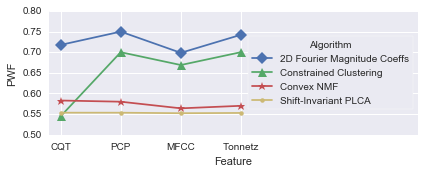

                                      sum_sq      df           F  \
C(Algorithm, Sum)                  13.183204     3.0  255.209239   
C(Feature, Sum)                     0.933705     3.0   18.075279   
C(Algorithm, Sum):C(Feature, Sum)   2.247777     9.0   14.504652   
Residual                           47.661685  2768.0         NaN   

                                          PR(>F)  
C(Algorithm, Sum)                  3.250052e-146  
C(Feature, Sum)                     1.293014e-11  
C(Algorithm, Sum):C(Feature, Sum)   3.492655e-23  
Residual                                     NaN  
Friedman test
Test statistic: 285.300431034
Class rank sums: 2154.0
p-value for  3 degree of freedom: 1.50974689818e-61
class ranks
1670.0
p-value for  3 degree of freedom: 1.50974689818e-61
class ranks
1349.5
p-value for  3 degree of freedom: 1.50974689818e-61
class ranks
1786.5
p-value for  3 degree of freedom: 1.50974689818e-61
class ranks
  1 2154.0
  2 1670.0
  3 1349.5
  4 1786.5
Friedmanchisqua

In [133]:
# ANOVA on Labels
algo_ids = []
features = []
scores = []
G = []
for curr_file in results_features_files:
    algo_id, feature, annotator = get_result_attributes(curr_file, "labelsE")
    if algo_id == "olda" or algo_id == "scluster":
        continue
    if "boundsEgt" in curr_file:
        results = pd.read_csv(curr_file)
        G.append(results[label_metric])
        for result in results[label_metric]:
            scores.append(result)
            features.append(feature)
            algo_ids.append(algorithm_dict[algo_id])

# To DataFrame
d = { 
     "Algorithm"  : np.asarray(algo_ids),
     "Feature" : np.asarray(features),
     "Score"      : np.asarray(scores)
    }
df = pd.DataFrame(d)

print np.unique(df["Algorithm"])
N = len(np.unique(df["Algorithm"]))

# PLOT
plt.figure(figsize=(6,2.5))
interaction_plot(df["Feature"], df["Algorithm"],
                 df["Score"], colors=colors_labels[:3] + [colors_labels[4]],
                 markers=markers_labels[:3] + [markers_labels[4]], ms=9, ax=plt.gca(), legendloc="center right")
plt.gca().set_ylim([0.5, 0.8])
plt.gca().set_xlim([-0.2, 5.95])
plt.gca().set_xticklabels(xticks)
plt.ylabel("PWF")
plt.tight_layout()
plt.savefig("../figs/features_labels_anova.pdf")
plt.show()

sum_lm = ols("Score ~ C(Algorithm, Sum) * C(Feature, Sum)", data=df).fit()
print anova_lm(sum_lm, typ=2)

G = np.asarray(G).reshape((len(np.unique(df["Feature"])), 174 * len(np.unique(df["Algorithm"])))) 
# G = np.asarray(G).reshape((len(np.unique(df["Algorithm"])), len(np.unique(df["Feature"]))))
friedman(G, alpha = 0.05, ignoreties = False, onetailed = True, verbose = True)
print friedmanchisquare(*G)

In [134]:
import numpy as np
import scipy.special as special

def FPvalue( *args):
    """ Return F an p value

    """
    df_btwn, df_within = __degree_of_freedom_( *args)

    mss_btwn = __ss_between_( *args) / float( df_btwn)   
    mss_within = __ss_within_( *args) / float( df_within)

    F = mss_btwn / mss_within    
    P = special.fdtrc( df_btwn, df_within, F)

    return( F, P)

def EffectSize( *args):
    """ Return the eta squared as the effect size for ANOVA

    """    
    return( float( __ss_between_( *args) / __ss_total_( *args)))

def __concentrate_( *args):
    """ Concentrate input list-like arrays

    """
    v = list( map( np.asarray, args))
    vec = np.hstack( np.concatenate( v))
    return( vec)

def __ss_total_( *args):
    """ Return total of sum of square

    """
    vec = __concentrate_( *args)
    ss_total = sum( (vec - np.mean( vec)) **2)
    return( ss_total)

def __ss_between_( *args):
    """ Return between-subject sum of squares

    """    
    # grand mean
    grand_mean = np.mean( __concentrate_( *args))

    ss_btwn = 0
    for a in args:
        ss_btwn += ( len(a) * ( np.mean( a) - grand_mean) **2)

    return( ss_btwn)

def __ss_within_( *args):
    """Return within-subject sum of squares

    """
    return( __ss_total_( *args) - __ss_between_( *args))

def __degree_of_freedom_( *args):
    """Return degree of freedom

       Output-
              Between-subject dof, within-subject dof
    """   
    args = list( map( np.asarray, args))
    # number of groups minus 1
    df_btwn = len( args) - 1

    # total number of samples minus number of groups
    df_within = len( __concentrate_( *args)) - df_btwn - 1

    return( df_btwn, df_within)

In [135]:
from scipy import stats

bound_experiments = []
for key in bound_scores.keys():
    if boundsID_str not in key:
        print key
        if "noctavesE7" in key:
            bound_experiments.append(np.array(bound_scores[key][0]))

print FPvalue(*bound_experiments)
print __degree_of_freedom_(*bound_experiments)

noctavesE6_fminE27.5
noctavesE5_fminE27.5
noctavesE7_fminE38.9
noctavesE6_fminE30.9
noctavesE6_fminE49.0
noctavesE4_fminE30.9
noctavesE7_fminE30.9
noctavesE5_fminE43.7
noctavesE5_fminE34.6
noctavesE6_fminE43.7
noctavesE6_fminE34.6
noctavesE4_fminE43.7
noctavesE5_fminE38.9
noctavesE4_fminE49.0
noctavesE5_fminE49.0
noctavesE4_fminE27.5
noctavesE5_fminE30.9
noctavesE4_fminE34.6
noctavesE7_fminE34.6
noctavesE6_fminE38.9
noctavesE7_fminE27.5
noctavesE4_fminE38.9
(0.0038348887466734404, 0.99967258756596578)
(3, 692)


In [136]:
stats.f_oneway(*bound_experiments)

F_onewayResult(statistic=0.0038348887466727239, pvalue=0.99967258756596578)

# Algorithms #

Running label algorithms on all the different boundaries results on The Beatles TUT dataset.

In [137]:
results_algorithms_path = "results_algorithms"
results_algorithms_files = glob.glob(os.path.join(data_path, results_algorithms_path, "*.csv"))
xticks = ["Human", "SF", "Laplacian", "CC", "OLDA", "Checkboard", "C-NMF", "SI-PLCA"]

fmc2d
cnmf
siplca
cc
scluster
['2D Fourier Magnitude Coeffs' 'Constrained Clustering' 'Convex NMF'
 'Laplacian Segmentation' 'Shift-Invariant PLCA']


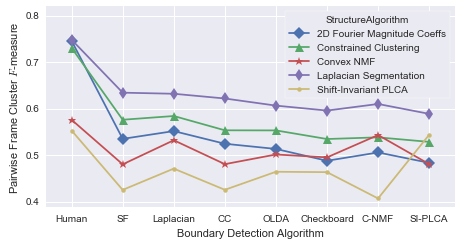

                                                       sum_sq      df  \
C(StructureAlgorithm, Sum)                          20.750283     4.0   
C(BoundaryAlgorithm, Sum)                           16.308552     7.0   
C(StructureAlgorithm, Sum):C(BoundaryAlgorithm,...   5.857881    28.0   
Residual                                            88.049481  6920.0   

                                                             F         PR(>F)  
C(StructureAlgorithm, Sum)                          407.702452  6.952535e-316  
C(BoundaryAlgorithm, Sum)                           183.103501  9.295104e-250  
C(StructureAlgorithm, Sum):C(BoundaryAlgorithm,...   16.442272   6.305737e-77  
Residual                                                   NaN            NaN  
Friedman test
Test statistic: 225.052873563
Class rank sums: 490
p-value for  4 degree of freedom: 1.53280336275e-47
class ranks
560
p-value for  4 degree of freedom: 1.53280336275e-47
class ranks
277
p-value for  4 degree of freedom:

225.05287356321833

In [138]:
# ANOVA of the combination of algorithms for labels
bound_ids = []
label_ids = []
scores = []
G = []
for curr_file in results_algorithms_files:
    bound_id, feature, annotator = get_result_attributes(curr_file, "bounds")
    label_id, feature, annotator = get_result_attributes(curr_file, "labels")
    results = pd.read_csv(curr_file)
#     if label_id == "cnmf" or label_id == "siplca":# or bound_id == "gt":
#         continue
#     print results
#     print label_id
    if bound_id == "gt":
        bound_id = "a_gt"
    if bound_id == "sf":
        bound_id = "b_sf"
    if bound_id == "scluster":
        bound_id = "c_laplacian"
    if bound_id == "cc":
        bound_id = "d_cc"
    if bound_id == "olda":
        bound_id = "e_olda"
    if bound_id == "foote":
        bound_id = "f_foote"
    if bound_id == "cnmf":
        bound_id = "g_cnmf"
        print label_id
        G.append(results[label_metric])
    if bound_id == "siplca":
        bound_id = "h_siplca"
    for result in results[label_metric]:
        scores.append(result)
        bound_ids.append(bound_id)
        label_ids.append(algorithm_dict[label_id])

# To DataFrame
d = { 
     "StructureAlgorithm"  : np.asarray(label_ids),
     "BoundaryAlgorithm" : np.asarray(bound_ids),
     "Score"      : np.asarray(scores)
    }
df = pd.DataFrame(d)

print np.unique(df["StructureAlgorithm"])
N = len(np.unique(df["StructureAlgorithm"]))

# PLOT
plt.figure(figsize=(6.5,3.5))
interaction_plot(df["BoundaryAlgorithm"], df["StructureAlgorithm"],
                 df["Score"], colors=colors_labels,
                 markers=markers_labels[:N], ms=9, ax=plt.gca(), legendloc="upper right")
plt.gca().set_ylim([0.39, 0.82])
plt.gca().set_xlim([-0.5, 7.5])
plt.gca().set_xticklabels(xticks)
plt.xlabel("Boundary Detection Algorithm")
plt.ylabel("Pairwise Frame Cluster $F$-measure")
plt.tight_layout()
plt.savefig("../figs/algorithms_anova.pdf")
plt.show()

sum_lm = ols("Score ~ C(StructureAlgorithm, Sum) * C(BoundaryAlgorithm, Sum)", data=df).fit()
print anova_lm(sum_lm, typ=2)

# G = np.asarray(G).reshape((len(np.unique(df["BoundaryAlgorithm"])), 174 * len(np.unique(df["LabelAlgorithm"])))) 
# G = np.asarray(G).reshape((len(np.unique(df["BoundaryAlgorithm"])), len(np.unique(df["LabelAlgorithm"]))))
# print G.T
# friedman(G, alpha = 0.05, ignoreties = False, onetailed = True, verbose = True)
# K = []
# off = 5
# for i in xrange(0 + off, 5 + off):
#     K.append(G[i])
#     print np.mean(G[i])
friedman(G, alpha = 0.05, ignoreties = False, onetailed = True, verbose = True)    

# Datasets

Check for the variation in algorithms depending on the dataset. It would be interesting to show that some algorithms perform better than others depending on the dataset.

In [160]:
results_datasets_path = "results_datasets"
results_datasets_files = glob.glob(os.path.join(data_path, results_datasets_path, "*.csv"))
bound_metric = "HitRate_3F"
xticks = ["Beatles", "Cerulean", "Epiphyte", "Isophonics", "SALAMI", "Sargon", "SPAM"]

['Checkerboard Kernel' 'Constrained Clustering' 'Convex NMF'
 'Laplacian Segmentation' 'Ordinal LDA' 'Shift-Invariant PLCA'
 'Structural Features']


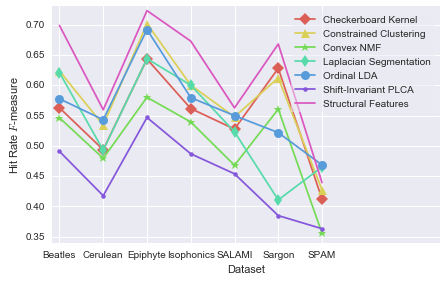

                                       sum_sq       df           F  \
C(Algorithm, Sum)                   42.071109      6.0  333.578383   
C(Dataset, Sum)                     64.722268      6.0  513.177570   
C(Algorithm, Sum):C(Dataset, Sum)    4.203679     36.0    5.555105   
Residual                           349.459189  16625.0         NaN   

                                         PR(>F)  
C(Algorithm, Sum)                  0.000000e+00  
C(Dataset, Sum)                    0.000000e+00  
C(Algorithm, Sum):C(Dataset, Sum)  1.910309e-24  
Residual                                    NaN  
Friedman test
Test statistic: 5.51020408163
Class rank sums: 21
p-value for  6 degree of freedom: 0.480224261607
class ranks
34
p-value for  6 degree of freedom: 0.480224261607
class ranks
24
p-value for  6 degree of freedom: 0.480224261607
class ranks
22
p-value for  6 degree of freedom: 0.480224261607
class ranks
31
p-value for  6 degree of freedom: 0.480224261607
class ranks
31
p-value for  6 

In [174]:
# ANOVA on Boundaries
algo_ids = []
ds_names = []
scores = []
G = []
for curr_file in results_datasets_files:
    if "labelsENone" in curr_file:
        algo_id, feature, annotator = get_result_attributes(curr_file, "bounds")
        ds_name = os.path.basename(curr_file).split("_")[1]
        if ds_name == "BeatlesTUT":
            ds_name = "Beatles"
        if ds_name == "SPAM":
            ds_name = "spam"
        results = pd.read_csv(curr_file)
        G.append(results[bound_metric].mean())
        for result in results[bound_metric]:
            scores.append(result)
            ds_names.append(ds_name)
            algo_ids.append(algorithm_dict[algo_id])

# To DataFrame
d = { 
     "Algorithm"  : np.asarray(algo_ids),
     "Dataset" : np.asarray(ds_names),
     "Score"      : np.asarray(scores)
    }
df = pd.DataFrame(d)

print np.unique(df["Algorithm"])
N = len(np.unique(df["Algorithm"]))

# PLOT
plt.figure(figsize=(6.3, 4))
interaction_plot(df["Dataset"], df["Algorithm"],
                 df["Score"], colors=colors_bounds[:N],
                 markers=markers[:N], ms=9, ax=plt.gca(), legendloc="upper right")
leg = plt.legend()
leg.get_frame().set_alpha(0.5)
plt.gca().set_ylim([0.34, .73])
plt.gca().set_xlim([-0.18, 8.7])
plt.gca().set_xticklabels(xticks)
plt.ylabel("Hit Rate $F$-measure")
plt.tight_layout()
plt.savefig("../figs/datasets_bounds_anova.pdf")
plt.show()

sum_lm = ols("Score ~ C(Algorithm, Sum) * C(Dataset, Sum)", data=df).fit()
print anova_lm(sum_lm, typ=2)

G = np.asarray(G).reshape((len(np.unique(df["Algorithm"])), len(np.unique(df["Dataset"]))))
# G = np.asarray(G).reshape((len(np.unique(df["Feature"])), 174 * len(np.unique(df["Algorithm"]))))
friedman(G, alpha = 0.05, ignoreties = False, onetailed = True, verbose = True)
print friedmanchisquare(*G)

['2D Fourier Magnitude Coeffs' 'Constrained Clustering' 'Convex NMF'
 'Laplacian Segmentation' 'Shift-Invariant PLCA']


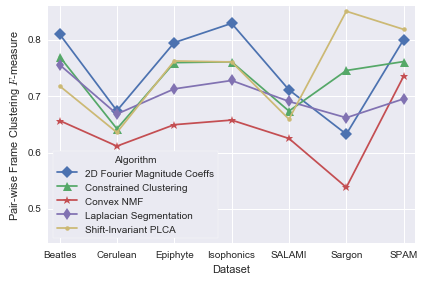

                                       sum_sq       df           F  \
C(Algorithm, Sum)                   19.814548      4.0  274.812110   
C(Dataset, Sum)                     14.401993      6.0  133.162840   
C(Algorithm, Sum):C(Dataset, Sum)    4.205640     24.0    9.721483   
Residual                           214.053298  11875.0         NaN   

                                          PR(>F)  
C(Algorithm, Sum)                  2.593986e-226  
C(Dataset, Sum)                    8.699285e-164  
C(Algorithm, Sum):C(Dataset, Sum)   8.256655e-36  
Residual                                     NaN  
Friedman test
Test statistic: 6.62857142857
Class rank sums: 24
p-value for  4 degree of freedom: 0.156867474908
class ranks
21
p-value for  4 degree of freedom: 0.156867474908
class ranks
14
p-value for  4 degree of freedom: 0.156867474908
class ranks
28
p-value for  4 degree of freedom: 0.156867474908
class ranks
18
p-value for  4 degree of freedom: 0.156867474908
class ranks
  1   24.0
  

In [167]:
# ANOVA on Labels
algo_ids = []
ds_names = []
scores = []
G = []
for curr_file in results_datasets_files:
    if "boundsEgt" in curr_file:
        algo_id, feature, annotator = get_result_attributes(curr_file, "labels")
        ds_name = os.path.basename(curr_file).split("_")[1]
        results = pd.read_csv(curr_file)
        G.append(results[label_metric].mean())
        if ds_name == "SPAM":
            ds_name = "spam"
        for result in results[label_metric]:
            scores.append(result)
            ds_names.append(ds_name)
            algo_ids.append(algorithm_dict[algo_id])

# To DataFrame
d = { 
     "Algorithm"  : np.asarray(algo_ids),
     "Dataset" : np.asarray(ds_names),
     "Score"      : np.asarray(scores)
    }
df = pd.DataFrame(d)

print np.unique(df["Algorithm"])

N = len(np.unique(df["Algorithm"]))

# PLOT
plt.figure(figsize=(6,4))
interaction_plot(df["Dataset"], df["Algorithm"],
                 df["Score"], colors=colors_labels,
                 markers=markers_labels[:N], ms=9, ax=plt.gca(), legendloc="lower left")
plt.gca().set_ylim([0.44, .86])
plt.gca().set_xlim([-0.2, 6.2])
plt.ylabel("Pair-wise Frame Clustering $F$-measure")
plt.gca().set_xticklabels(xticks)
plt.tight_layout()
plt.savefig("../figs/datasets_labels_anova.pdf")
plt.show()

sum_lm = ols("Score ~ C(Algorithm, Sum) * C(Dataset, Sum)", data=df).fit()
print anova_lm(sum_lm, typ=2)

G = np.asarray(G).reshape((len(np.unique(df["Algorithm"])), len(np.unique(df["Dataset"]))))
friedman(G, alpha = 0.05, ignoreties = False, onetailed = True, verbose = True)
print friedmanchisquare(*G)

# Annotations

Check how much the algorithm's scores change depending on the annotator.

6 different annotators in the Cerulean Dataset.

In [142]:
results_annotations_path = "results_annotations"
results_annotations_files = glob.glob(os.path.join(data_path, results_annotations_path, "*.csv"))

scluster
foote
cc
olda
siplca
cnmf
['Checkerboard Kernel' 'Constrained Clustering' 'Convex NMF'
 'Laplacian Segmentation' 'Ordinal LDA' 'Shift-Invariant PLCA'
 'Structural Features']
6


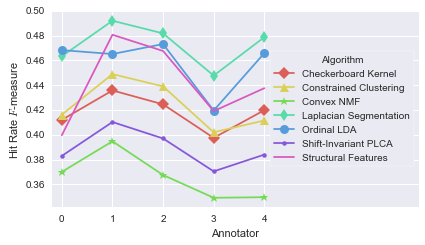

                                        sum_sq      df          F  \
C(Algorithm, Sum)                     2.119406     6.0  13.065266   
C(Annotator, Sum)                     0.438317     4.0   4.053071   
C(Algorithm, Sum):C(Annotator, Sum)   0.158675    24.0   0.244541   
Residual                             46.096615  1705.0        NaN   

                                           PR(>F)  
C(Algorithm, Sum)                    1.687590e-14  
C(Annotator, Sum)                    2.830462e-03  
C(Algorithm, Sum):C(Annotator, Sum)  9.999393e-01  
Residual                                      NaN  
Friedman test
Test statistic: 28.2142857143
Class rank sums: 195.0
p-value for  5 degree of freedom: 3.30507879384e-05
class ranks
176.0
p-value for  5 degree of freedom: 3.30507879384e-05
class ranks
187.0
p-value for  5 degree of freedom: 3.30507879384e-05
class ranks
215.0
p-value for  5 degree of freedom: 3.30507879384e-05
class ranks
146.5
p-value for  5 degree of freedom: 3.30507879384

28.21428571428578

In [143]:
# ANOVA on Boundaries
algo_ids = []
annotators = []
scores = []
G = []
bound_metric = "HitRate_3F"
for curr_file in results_annotations_files:
    if "labelsENone" in curr_file:
        algo_id, feature, annotator = get_result_attributes(curr_file, "bounds")
        results = pd.read_csv(curr_file)
        if annotator == "0":
            if len(results[bound_metric]) == 50:
                print algo_id
                G.append(results[bound_metric])
#         print len(results[bound_metric]), algo_id, feature, annotator
        for result in results[bound_metric]:
            scores.append(result)
            annotators.append(annotator)
            algo_ids.append(algorithm_dict[algo_id])

# To DataFrame
d = { 
     "Algorithm"  : np.asarray(algo_ids),
     "Annotator" : np.asarray(annotators),
     "Score"      : np.asarray(scores)
    }
df = pd.DataFrame(d)

print np.unique(d["Algorithm"])
N = len(np.unique(d["Algorithm"]))
print len(G)

# PLOT
plt.figure(figsize=(6,3.5))
interaction_plot(df["Annotator"], df["Algorithm"],
                 df["Score"], colors=colors_bounds[:N],
                 markers=markers[:N], ms=9, ax=plt.gca(), legendloc="center right")
plt.gca().set_ylim([0.342, 0.5])
plt.gca().set_xlim([-0.2, 7.05])
plt.ylabel("Hit Rate $F$-measure")
plt.tight_layout()
plt.savefig("../figs/annotators_bounds_anova.pdf")
plt.show()

sum_lm = ols("Score ~ C(Algorithm, Sum) * C(Annotator, Sum)", data=df).fit()
print anova_lm(sum_lm, typ=2)

# G = np.asarray(G).reshape((len(np.unique(df["Algorithm"])), len(np.unique(df["Annotator"]))))
friedman(G, alpha = 0.05, ignoreties = False, onetailed = True, verbose = True)

['2D Fourier Magnitude Coeffs' 'Constrained Clustering' 'Convex NMF'
 'Laplacian Segmentation' 'Shift-Invariant PLCA']


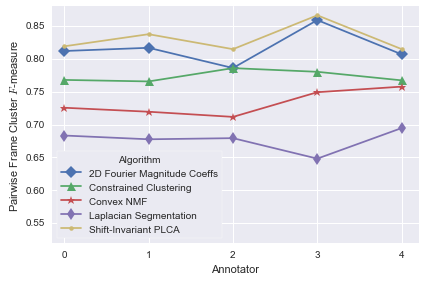

                                        sum_sq      df          F  \
C(Algorithm, Sum)                     3.960361     4.0  48.298942   
C(Annotator, Sum)                     0.088493     4.0   1.079223   
C(Algorithm, Sum):C(Annotator, Sum)   0.306469    16.0   0.934391   
Residual                             25.111536  1225.0        NaN   

                                           PR(>F)  
C(Algorithm, Sum)                    9.364459e-38  
C(Annotator, Sum)                    3.653229e-01  
C(Algorithm, Sum):C(Annotator, Sum)  5.287079e-01  
Residual                                      NaN  


In [157]:
# ANOVA on Labels
algo_ids = []
annotators = []
scores = []
for curr_file in results_annotations_files:
    if "boundsEgt" in curr_file:
        algo_id, feature, annotator = get_result_attributes(curr_file, "labels")
        results = pd.read_csv(curr_file)
        for result in results[label_metric]:
            scores.append(result)
            annotators.append(annotator)
            algo_ids.append(algorithm_dict[algo_id])

# To DataFrame
d = { 
     "Algorithm"  : np.asarray(algo_ids),
     "Annotator" : np.asarray(annotators),
     "Score"      : np.asarray(scores)
    }
df = pd.DataFrame(d)

print np.unique(d["Algorithm"])
N = len(np.unique(d["Algorithm"]))

# PLOT
plt.figure(figsize=(6,4))
interaction_plot(df["Annotator"], df["Algorithm"],
                 df["Score"], colors=colors_labels,
                 markers=markers_labels[:N], ms=9, ax=plt.gca(), legendloc="lower left")
plt.gca().set_ylim([0.52, .88])
plt.gca().set_xlim([-0.15, 4.2])
plt.ylabel("Pairwise Frame Cluster $F$-measure")
plt.tight_layout()
plt.savefig("../figs/annotators_labels_anova.pdf")
plt.show()

sum_lm = ols("Score ~ C(Algorithm, Sum) * C(Annotator, Sum)", data=df).fit()
print anova_lm(sum_lm, typ=2)

# Evaluation Metrics #

See differences in algorithm ranking depending on the evaluation metric:

Boundaries:
* Hit Rate 3-sec
* Hit Rate 0.5-sec
* Hit Rate 3-sec Trimmed
* Hit Rate 0.5-sec Trimmed
* Hit Rate 3-sec (weighted)
* Hit Rate 0.5-sec (weighted)
* Standard Deviations

Structural Grouping
* Pairwise Frame Clustering
* Normalized Entropy Scores


In [145]:
results_datasets_path = "results_datasets"
results_datasets_files = glob.glob(os.path.join(data_path, results_datasets_path, "*.csv"))
bound_metrics = ["HitRate_3F", "HitRate_t3F", "HitRate_0.5F", "HitRate_t0.5F", "DevE2R", "DevR2E"]
# bound_metrics = ["HitRate_3F", "HitRate_t3F", "HitRate_0.5F", "HitRate_t0.5F"]
label_metrics = ["PWF", "Sf"]
import mir_eval

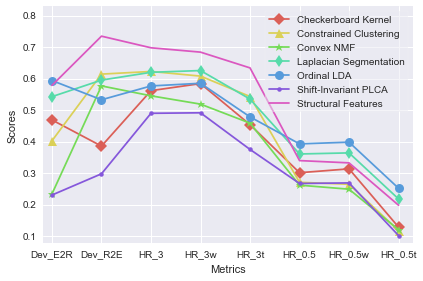

                                       sum_sq      df           F  \
C(Algorithm, Sum)                   43.811074     6.0  118.025422   
C(Metrics, Sum)                    198.563425     7.0  458.505051   
C(Algorithm, Sum):C(Metrics, Sum)   29.197647    42.0   11.236770   
Residual                           599.364782  9688.0         NaN   

                                          PR(>F)  
C(Algorithm, Sum)                  2.116668e-144  
C(Metrics, Sum)                     0.000000e+00  
C(Algorithm, Sum):C(Metrics, Sum)   4.482812e-72  
Residual                                     NaN  
Friedman test
Test statistic: 210.677339901
Class rank sums: 713.5
p-value for  6 degree of freedom: 1.01015441485e-42
class ranks
938.5
p-value for  6 degree of freedom: 1.01015441485e-42
class ranks
569.0
p-value for  6 degree of freedom: 1.01015441485e-42
class ranks
794.5
p-value for  6 degree of freedom: 1.01015441485e-42
class ranks
490.0
p-value for  6 degree of freedom: 1.01015441485e-42


210.67733990147826

In [146]:
# ANOVA on Boundaries
algo_ids = []
metrics = []
scores = []
xticks = ["Dev_E2R", "Dev_R2E", "HR_3", "HR_3w", "HR_3t", "HR_0.5", "HR_0.5w", "HR_0.5t"]
G = []
for curr_file in results_datasets_files:
    if "labelsENone" in curr_file:
        algo_id, feature, annotator = get_result_attributes(curr_file, "bounds")
        ds_name = os.path.basename(curr_file).split("_")[1]
        if ds_name != "BeatlesTUT":
            continue
        results = pd.read_csv(curr_file)
        for bound_metric in bound_metrics:
            if bound_metric == "HitRate_0.5F":
                G.append(results[bound_metric])
            for result in results[bound_metric]:
                metric_name = bound_metric
                if bound_metric == "HitRate_3F":
                    metric_name = "E_HitRate_3F"
                if bound_metric == "HitRate_t3F":
                    metric_name = "E_HitRate_t3F"
                if bound_metric == "DevE2R" or bound_metric == "DevR2E":
                    result = 1 - result / 4.
                scores.append(result)
                metrics.append(metric_name)
                algo_ids.append(algorithm_dict[algo_id])
            if bound_metric == "HitRate_3F":
                metric_name = "E_HitRate_3Fw"
                for P, R in zip(results["HitRate_3P"], results["HitRate_3R"]):
                    scores.append(mir_eval.util.f_measure(P, R, beta=0.58))
                    metrics.append(metric_name)
                    algo_ids.append(algorithm_dict[algo_id])
            if bound_metric == "HitRate_0.5F":
                metric_name = "HitRate_0.5Fw"
                for P, R in zip(results["HitRate_0.5P"], results["HitRate_0.5R"]):
                    scores.append(mir_eval.util.f_measure(P, R, beta=0.58))
                    metrics.append(metric_name)
                    algo_ids.append(algorithm_dict[algo_id])
                    

# To DataFrame
d = { 
     "Algorithm"  : np.asarray(algo_ids),
     "Metrics" : np.asarray(metrics),
     "Score"      : np.asarray(scores)
    }
df = pd.DataFrame(d)

anova_len = len(np.unique(df["Algorithm"]))

# PLOT
plt.figure(figsize=(6,4))
fig = interaction_plot(df["Metrics"], df["Algorithm"],
                 df["Score"], colors=colors_bounds[:anova_len],
                 markers=markers[:anova_len], ms=9, ax=plt.gca(), legendloc="upper right")
leg = plt.legend()
leg.get_frame().set_alpha(0.5)
plt.gca().set_ylim([0.08, 0.83])
plt.gca().set_xlim([-0.18, 7.3])
plt.gca().set_xticklabels(xticks)
plt.ylabel("Scores")
plt.tight_layout()
plt.savefig("../figs/evaluation_bounds_anova.pdf")
plt.show()

sum_lm = ols("Score ~ C(Algorithm, Sum) * C(Metrics, Sum)", data=df).fit()
print anova_lm(sum_lm, typ=2)

friedman(G, alpha = 0.05, ignoreties = False, onetailed = True, verbose = True)

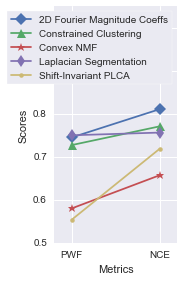

                                      sum_sq      df           F  \
C(Algorithm, Sum)                   7.583083     4.0  134.490329   
C(Metrics, Sum)                     2.235710     1.0  158.606404   
C(Algorithm, Sum):C(Metrics, Sum)   1.208854     4.0   21.439714   
Residual                           24.386017  1730.0         NaN   

                                          PR(>F)  
C(Algorithm, Sum)                  3.974582e-100  
C(Metrics, Sum)                     7.338198e-35  
C(Algorithm, Sum):C(Metrics, Sum)   2.794478e-17  
Residual                                     NaN  
Friedman test
Test statistic: 230.105747126
Class rank sums: 658.5
p-value for  4 degree of freedom: 1.25264434686e-48
class ranks
623.5
p-value for  4 degree of freedom: 1.25264434686e-48
class ranks
359.5
p-value for  4 degree of freedom: 1.25264434686e-48
class ranks
629.0
p-value for  4 degree of freedom: 1.25264434686e-48
class ranks
339.5
p-value for  4 degree of freedom: 1.25264434686e-48
class

230.10574712643665

In [147]:
# ANOVA on Boundaries
algo_ids = []
metrics = []
scores = []
xticks = ["PWF", "NCE"]
G = []
for curr_file in results_datasets_files:
    if "boundsEgt" in curr_file:
        algo_id, feature, annotator = get_result_attributes(curr_file, "labels")
        ds_name = os.path.basename(curr_file).split("_")[1]
        if ds_name != "BeatlesTUT":
            continue
        results = pd.read_csv(curr_file)
        for label_metric in label_metrics:
            if label_metric == "PWF":
                G.append(results[label_metric])
            for result in results[label_metric]:
                scores.append(result)
                metrics.append(label_metric)
                algo_ids.append(algorithm_dict[algo_id])

# To DataFrame
d = { 
     "Algorithm"  : np.asarray(algo_ids),
     "Metrics" : np.asarray(metrics),
     "Score"      : np.asarray(scores)
    }
df = pd.DataFrame(d)

anova_len = len(np.unique(df["Algorithm"]))

# PLOT
plt.figure(figsize=(2.5,4))
interaction_plot(df["Metrics"], df["Algorithm"],
                 df["Score"], colors=colors_labels,
                 markers=markers_labels[:anova_len], ms=9, ax=plt.gca(), legendloc="upper center")
leg = plt.legend()
# leg.get_frame().set_alpha(0.5)
plt.gca().set_ylim([0.5, 1.05])
plt.gca().set_xlim([-0.2, 1.2])
plt.gca().set_xticklabels(xticks)
plt.ylabel("Scores")
plt.tight_layout()
plt.savefig("../figs/evaluation_labels_anova.pdf")
plt.show()

sum_lm = ols("Score ~ C(Algorithm, Sum) * C(Metrics, Sum)", data=df).fit()
print anova_lm(sum_lm, typ=2)

friedman(G, alpha = 0.05, ignoreties = False, onetailed = True, verbose = True)